# Assess distribution of precipitation to partition to cloud height categories

In [2]:
# preamble

# set up environments base -> ATOMIC_GOES
# IJulia and Revise must be installed in the Julia base @version package environment.
# Sometimes perhaps an vscode extension
using Revise # does using Revise first allow for revising code in ATOMIC_GOES???
using Pkg
# Pkg.activate(joinpath(homedir(), "Projects/ATOMIC/ATOMIC_GOES/julia/ATOMIC_GOES"))
Pkg.activate(".")

# using ATOMIC_GOES
# using ATOMIC_GOES.DataIO

using Printf
# using FileIO
using Dates
using NCDatasets
using JLD2

# using StatsBase
using ForwardDiff
using Statistics
using Interpolations
# using DSP

using PyPlot
# using PyCall
# using CSV

  Activating project at `~/Projects/ATOMIC/ATOMIC_GOES/julia/RHB/sonde`


In [3]:
# utility functions; extend matplotlib

# use numpy masking for missing
using PyCall
using PyCall: PyObject

# allow for plotting with missing values
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

"plotf(f, x, args...)  function plot wrapper"
plotf(f, x, args...) = plot(f.(x), x, args...)

"midpoint averager"
mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16

"missing to zero"
# m2z(x) = ismissing(x) ? 0 : x
m2z(x) = replace(x, missing=>0)

# statistics fcns
"anomaly"
anom(r, kwargs...) = r .- mean(r, kwargs...)

"runningmean(x, n=7, f=isfinite) n-point running mean points satisfying f(x)==true"
function runningmean(x, n=7, f=isfinite)
    notf2zero(x) = f(x) ? x : 0
    cs = cumsum(notf2zero.(x))
    ct = cumsum(f.(x))
    (cs[n+1:end] .- cs[1:end-n]) ./ (ct[n+1:end] .- ct[1:end-n])
end

recurse(f, x, n) = n>0 ? f(recurse(f, x, n-1)) : x
"abstractly composes f n times; recursef(f,3) = f∘f∘f = x->f(f(f(x))), without evaluating"
recursef(f,n) = reduce(∘, ntuple(_ -> f, n)) 

"declare arrays with elements of Union{Missing,T} unions"
similarmissing(s::Tuple, T::Type=Float64) = Array{Union{Missing, T}}(missing, s)
similarmissing(A::Array) = similarmissing(size(A), eltype(A))

"moving_average(A, m) m-point moving average of A"
function moving_average(A::AbstractArray, m::Int, cond=x->true)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = m÷2 * oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            if cond(A[J]) # add condition, e.g. isfinite
                s += A[J]
                n += 1
            end
        end
        out[I] = s/n
    end
    return out
end

moving_average

In [4]:
module VaporSat

using ForwardDiff

export qsat, dqsdT, dlnqsdT
export Twet_autodiff

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K
Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = L0 + (Cpv-Cw) * (TempK-273.0)

# functions
"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5; P=p*1e-2)
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"T [C]; supplying TK [Kelvin] by keyword ignores positional T"
function es(T,p=1e5; TK=T+C, P=p*1e-2)
    T = TK - C
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # converts es to Pa
end

"""
qsat(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qsat [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
qsat(p,T) = RdoRv*es(T,p) / (p + (RdoRv-1)*es(T,p))

"dqsdT(p,T[C]) derivative of qsat with respect to T at p,T by autodiff of Bolton's qsat"
dqsdT(p,T) = ForwardDiff.derivative(t -> qsat(p,t), T)
dlnqsdT(p,T) = ForwardDiff.derivative(t -> log(qsat(p,t)), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qsat(pa, Ta)
# Twet_autodiff(Ta, rh*qsat(pa, Ta-C), pa) 

end # module VaporSat

┌ Warning: Replacing docs for `Main.VaporSat.es :: Union{Tuple{Any}, Tuple{Any, Any}}` in module `Main.VaporSat`
└ @ Base.Docs docs/Docs.jl:243


Main.VaporSat

In [5]:
# functions for thermodynamics

using .VaporSat
# exports dqsdT
# overloads some methods in VaporSat

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K


# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

# use method from VaporSat qsat(p[Pa], T[C])
# note order of arguments and units
# "qsat(T[C], p[hPa])"
# qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.

# adiabatic lapse rate
lapse_ad = gravity/Cp

"moist adiabatic lapse rate p[Pa], T[K]"
lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(p,T-KelvinCelsius)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(p,T-KelvinCelsius)/(Rd*Cp*T*T))
# lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(T-273.0,p)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(T-273.0,p)/(Rd*Cp*T*T))

"parcel process adiabatic change in saturation vapor pressure, p[Pa], T[K]"
dqsatdz_moistad(p,T) = dqsdT(p,T-KelvinCelsius) * -lapse_moist(T,p) # negative
# Small inconsistencies between dqsdT (Bolton) 
# and lapse_moist (Rogers and Yau) methods
# are OK here.

dqsatdz_moistad

In [ ]:
# data functions

# data wrangling functions
n2m(x) = isnan(x) ? missing : x
skipnan(x) = skipmissing(n2m.(x))

"Divide the range m:n into N bins (subranges), return arrays of first and last indices of bins."
function bins_inds(m::Integer, n::Integer, N)
    # emulate pythonic slice indexing to do the rounding consistently
    st = (n-m + 1) / N # step
    # round all p-slices correctly
    fst_p = floor.(Integer, m-1 : st : n-1)
    fst = fst_p .+ 1 # collect(fst_p .+ 1)
    lst = vcat(fst[2:end].-1, n)
    fst, lst
end

# test bins_inds
let m=1000, n=2000, N=12
    fst, lst = bins_inds(m, n, N)

    # bin sizes
    db = lst .- fst

    # all tests should return true
    (
        length(fst) == length(lst) == N,           # there are N bins
        fst[1] == m,                               # bins span the original indices
        lst[end] == n,
        all( lst[1:end-1] .== (fst[2:end] .- 1) ), # bins are contiguous 
        maximum(db) - minimum(db) <= 1             # bins are nearly the same size
    )
end

(true, true, true, true, true)

In [ ]:
# load data

# PSL flux data file
datapath = "./data" # -> /home/deszoeks/Data/ATOMIC/flux
psl = NCDataset(joinpath(datapath, "EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc"))

pmean = mean(skipmissing(psl["psealevel"][:]))
Tairsfcmean = mean(skipmissing(psl["tair"][:]))

rho = (1e2*pmean)/(Rd*(Tairsfcmean+273.15))
Lv(Tairsfcmean+273.15)
rhoL = rho * Lv(Tairsfcmean+273.15)
# E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2

# mean(skipmissing(psl["prate"][:])) # 0.032 mm/h
P0 = rhoL * mean(skipmissing(psl["prate"][:])) / 3600 # 0.032 mm/h -> 25.7 W/m^2

1.6666666666666667e-6

┌ Warning: cannot parse time units `seconds since 2020-01-01 00:00:00UTC`: ArgumentError: invalid base 10 digit 'U' in "00U"
└ @ CommonDataModel /home/deszoeks/.julia/packages/CommonDataModel/HZ4nE/src/cfvariable.jl:144


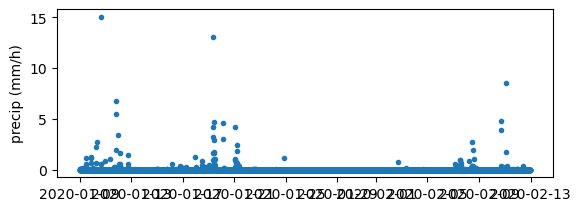

In [137]:
psldt = @. DateTime("2020-01-01T00:00:00") + Second(round(Int64,psl["time"][:]))
prate = psl["prate"][:] # mm/h

clf()
subplot(2,1,1)
plot(psldt, prate, linestyle="none", marker=".")
ylabel("precip (mm/h)")
gcf()

In [ ]:
n = length(prate)
s = sort(prate)
m = findfirst(s.>0)
cumarea = (1:n)/n
cumareaRain0 = m/n # cumulative area of first nonzero rain 0.96
m/n, s[m], (1-m/n)/0.2

# find power law of precipitation vs area. Doesn't fit well bc the peak precip climbs faster than a power law.
diff(log.(s[[m; end]]))[1] / diff(log.([m/n; 1]))[1]
pwr = log(s[end]/s[m]) / log(n/m)

148.80302643357368

In [155]:
# minimum rain rate sensitivity of 1-s samples is 0.001 mm/h, according to ORG2 documentation
# 0.001 / 600 = 1.67e-6 for a 10-minute average
s[m] 
# s[m] = 0.03 mm/h is well above the sample sensitivity floor of 0.001 mm/h.

0.030222857

Only the top 4% of times have any precipitation at all. If cloud fraction is 20%, then 20% of those clouds are measurably precipitating.

$$
P(a) = P_{max} a^p \\
p = \log(P_{max}/P(aR0)) / \log(1/aR0)
$$

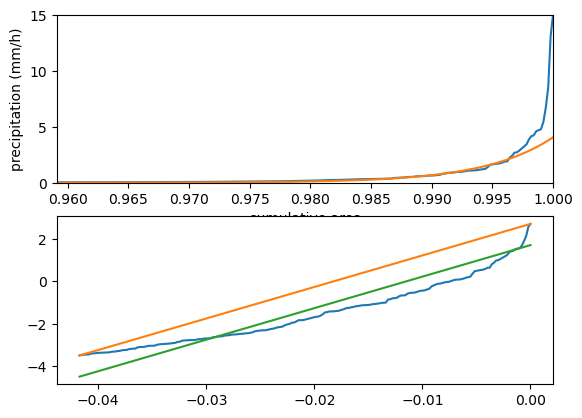

In [138]:
# plot precip and power law fits 
clf()
subplot(2,1,1)
plot((m:n)/n, s[m:end])
# plot(cumarea[m:n], 0.2*s[n] .* cumarea[m:n].^(pwr)) # fits lower precip, but not top 0.5%
plot(cumarea[m:n], 0.27*s[n] .* cumarea[m:n].^(1.2*pwr)) # fits but top 0.3%
# plot(cumarea[m:n], 0.3*s[n] .* cumarea[m:n].^(1.3*pwr)) 
xlim([m/n, 1])
ylim([0, s[end]])
ylabel("precipitation (mm/h)")
xlabel("cumulative area")

subplot(2,1,2)
plot(log.((m:n)/n), log.(s[m:end]))
plot(log.([m/n, 1]), log.(s[[m, end]]))
plot(log.([m/n, 1]), log.(s[[m, end]]).-1)
# xlim([m/n, 1])
# ylim([0, s[end]])
gcf()

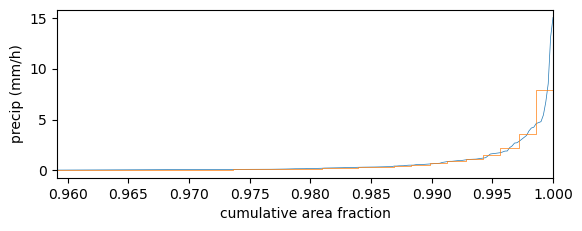

In [175]:
# divide the preciptiating part into bins
N = 28
fst, lst = bins_inds(m,n, N)
mb = [ mean(s[fst[i]:lst[i]]) for i in eachindex(fst) ] # mean precip in each bin

clf()
subplot(2,1,1)
plot((m:n)/n, s[m:end], linewidth=0.5)
plot(cumarea[[fst; lst[end]]], [mb; mb[end]], drawstyle="steps-post", linewidth=0.5)
xlim([m/n, 1])
ylabel("precip (mm/h)")
xlabel("cumulative area fraction")
gcf()